In [32]:
""""1. Find best HP set based on performance on valid set"""
import os, pickle, re
from datetime import datetime
import numpy as np
import pandas as pd
import torch
from Utils.utils import MinMaxScale_datasets
from Utils.prediction_models import TemporalCNN_Pr, SimpleFFNN_Pr, SimpleLSTM_Pr
### -------- Part 0: CONFIGURATION -------- ###

# -------- Sorting Utility -------- #
def sorting_key(idx):
    category_map = {'LC': 0, 'DT': 1, 'MI': 2, 'MLPSHAP': 3}
    category = next((v for k, v in category_map.items() if k in idx), 4)
    match = re.search(r'set(\d+)', idx)
    set_number = int(match.group(1)) if match else float('inf')
    return (category, set_number)

# -------- Configurations -------- #
farm = 'Kelmarsh'
model_choices = ['cnn']
target_feature = 'Generator bearing rear temperature (°C)'
sim = 1
metric = 'MSE'
fs_methods = ['LC', 'DT', 'MI', 'MLPSHAP']
pred_models = {
    'cnn': TemporalCNN_Pr,
    'lstm': SimpleLSTM_Pr,
    'ffnn': SimpleFFNN_Pr
}
valid_metrics_dict = {}

# -------- Load Data -------- #
with open(f'./1_healthy_datasets/{farm}_HealthyDatasets.pkl', 'rb') as f:
    healthy_datasets_raw = pickle.load(f)

# -------- Normalize -------- #
healthy_datasets = MinMaxScale_datasets(healthy_datasets_raw, target_feature)

# -------- Only using 1 dataset (can be expanded) -------- #
dataset_names = [list(healthy_datasets.keys())[1]]

# -------- Main Loop -------- #
for model_choice in model_choices:
    sim_name = f'sim{sim}_{model_choice}'

    for dataset_name in dataset_names:
        metrics_dir = f'./3_results/metrics/{sim_name}/{dataset_name}'
        grouped_metrics_valid = {}

        # -------- Group validation metrics by FS method and HP set -------- #
        for fname in os.listdir(metrics_dir):
            if not fname.endswith('.pkl'):
                continue

            parts = fname.split('_')
            group_key = f'{parts[4]}_{parts[5]}_{parts[6]}'
            filepath = os.path.join(metrics_dir, fname)

            with open(filepath, 'rb') as f:
                metrics_dict = pickle.load(f)
            valid_df = metrics_dict['valid'].set_index('METRIC')
            valid_df = valid_df.rename(columns={'VALUE': dataset_name})

            grouped_metrics_valid.setdefault(group_key, valid_df)
            if grouped_metrics_valid[group_key] is not valid_df:
                grouped_metrics_valid[group_key] = pd.concat([grouped_metrics_valid[group_key], valid_df], axis=1)

        # -------- Construct metric matrix across FS methods -------- #
        metric_rows = []
        for key in grouped_metrics_valid:
            metric_rows.append(grouped_metrics_valid[key].loc[metric].values)
        chosen_metric_df = pd.DataFrame(metric_rows, index=list(grouped_metrics_valid.keys()),
                                        columns=grouped_metrics_valid[next(iter(grouped_metrics_valid))].columns)
        chosen_metric_df = chosen_metric_df.reindex(sorted(chosen_metric_df.index, key=sorting_key))

        # -------- Reshape into FS method columns -------- #
        method_results = []
        for method in fs_methods:
            filtered = chosen_metric_df[chosen_metric_df.index.str.contains(method)]
            if not filtered.empty:
                method_results.append(filtered[dataset_name].values)
        result_df = pd.DataFrame(method_results).T
        result_df.columns = fs_methods

        valid_metrics_dict[f'{dataset_name}_{model_choice}'] = result_df

# -------- Part 3: Find Best HP Set per FS Method -------- #
for model_choice in model_choices:
    subdict = {k: v for k, v in valid_metrics_dict.items() if model_choice in k}
    best_sets = []

    for df in subdict.values():
        best_by_method = {
            method: (df[method].idxmin(), df[method].min())
            for method in df.columns
        }
        best_sets.append(best_by_method)

    best_sets_df = pd.DataFrame(best_sets, index=subdict.keys())

    #Save the best hps sets
    output_dir = f'./4_output/{model_choice}/'
    os.makedirs(output_dir, exist_ok=True)
    with open(f'{output_dir}/best_hp_sets_{model_choice}.pkl', 'wb') as f:
            pickle.dump(best_sets_df, f)
    
    

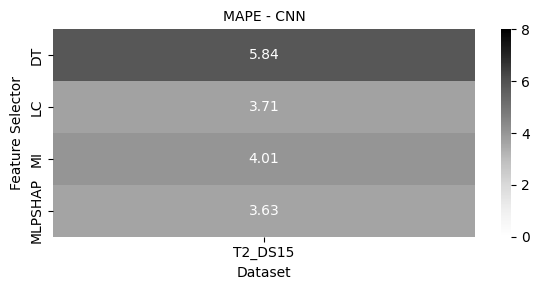

In [39]:
"""plot heatmap of chosen metric across sets and models"""
import seaborn as sns
import matplotlib.pyplot as plt

# -------- Configuration -------- #
test_results_dict = {}
show_heatmap = True
heatmap_metric = 'MAPE'
model_choices = ['cnn']

for model_choice in model_choices:
    
    #load in best hp_sets info (set num and mse)
    with open(f'{output_dir}/best_hp_sets_{model_choice}.pkl', 'rb') as f:
        best_sets_df = pickle.load(f)
        
    fs_methods = best_sets_df.columns
    test_results = pd.DataFrame(index=dataset_names, columns=fs_methods)

    for dataset_name in dataset_names:
        for fs_method in fs_methods:
            # --- Get best set info
            set_idx, _ = best_sets_df.loc[f'{dataset_name}_{model_choice}', fs_method]

            base_filename = f'{farm}_{dataset_name}_{model_choice}_{fs_method}_hpset{set_idx}'
            metrics_path = f'./3_results/metrics/{sim_name}/{dataset_name}/Metrics_{base_filename}.pkl'
            model_path = f'./3_results/models/{sim_name}/{dataset_name}/Model_{base_filename}.pkl'

            # --- Load metrics and model
            with open(metrics_path, 'rb') as f:
                metrics_dict = pickle.load(f)
            with open(model_path, 'rb') as f:
                model = pickle.load(f)

            # --- Extract test metric
            test_df = metrics_dict['test'].set_index('METRIC')
            test_results.loc[dataset_name, fs_method] = test_df.loc[heatmap_metric].values[0]

    # Ensure numeric values
    test_results = test_results.apply(pd.to_numeric, errors='coerce')

    # Melt for seaborn plotting
    test_melted = (
        test_results.reset_index()
        .rename(columns={'index': 'Dataset'})
        .melt(id_vars='Dataset', var_name='Feature Selector', value_name=heatmap_metric)
    )

    test_results_dict[model_choice] = test_melted

# -------- Plotting Heatmaps -------- #
if show_heatmap:
    n_models = len(test_results_dict)
    fig, axes = plt.subplots(n_models, 1, figsize=(6, 3 * n_models), squeeze=False)

    for i, (model_choice, df) in enumerate(test_results_dict.items()):
        pivot_data = df.pivot(index='Feature Selector', columns='Dataset', values=heatmap_metric)

        sns.heatmap(
            pivot_data,
            annot=True,
            fmt='.2f',
            cmap='Grays',
            vmin=0,
            vmax=8,
            ax=axes[i][0]
        )
        axes[i][0].set_title(f'{heatmap_metric} - {model_choice.upper()}', fontsize=10)

    plt.tight_layout()
    plt.show()


In [61]:
HPS['window_size']

np.float64(9.0)

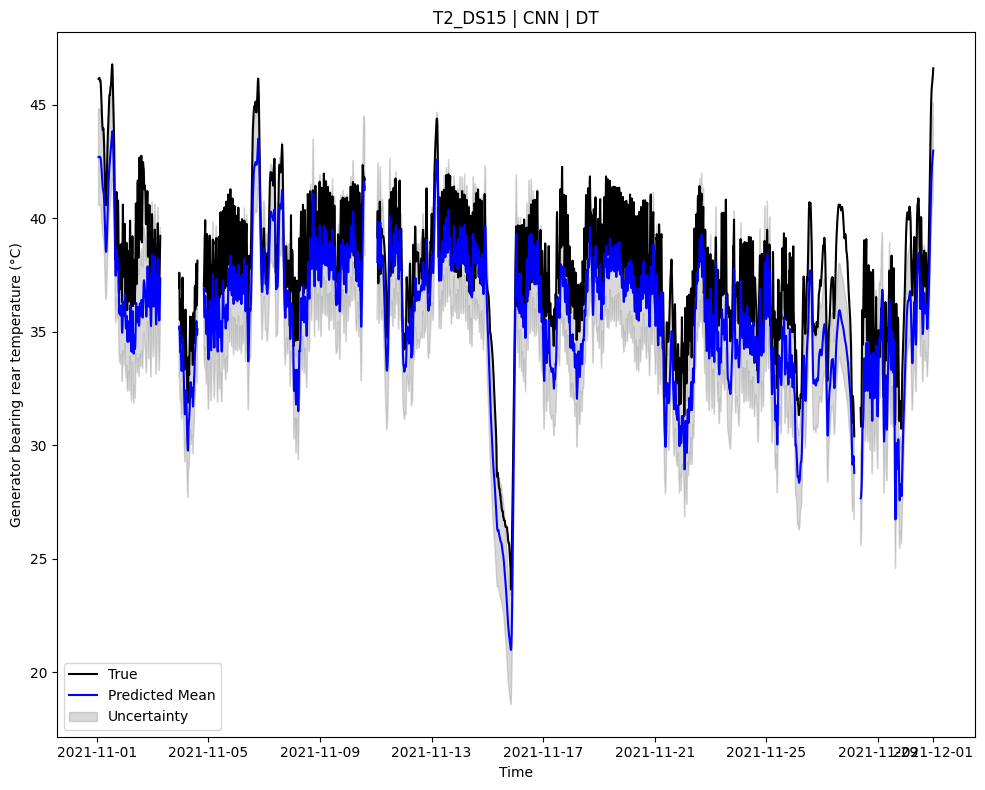

In [54]:
"""Plot a single subset for a chosen predictor, selector, farm, dataset"""
# --- Imports ---
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

from Utils.utils import segment_timeseries_v2, TimeseriesDataset
from Utils.prediction_models import TemporalCNN_Pr, SimpleFFNN_Pr, SimpleLSTM_Pr
from Utils.prediction_utils import pred_trained_model

# --- Configuration ---
farm = 'Kelmarsh'
dataset_plot = 'T2_DS15'
model_choice = 'cnn'  # 'cnn', 'lstm', or 'ffnn'
feature_selector = 'DT'
subset_to_plot = 'test'
sim = 1
fixed_hyperparams = {'steps_ahead': 0}
target_feature = 'Generator bearing rear temperature (°C)'

# --- Load Features ---
with open(f'./2_ordered_inputs/{farm}_ordered_inputs.pkl', 'rb') as f:
    chosen_features_dict = pickle.load(f)
all_features = chosen_features_dict[f'{dataset_plot}_{feature_selector}']

# --- Load Best HP Set ---
with open(f'./4_output/{model_choice}/best_hp_sets_{model_choice}.pkl', 'rb') as f:
    best_sets_df = pickle.load(f)
hp_set_num = best_sets_df[feature_selector][f'{dataset_plot}_{model_choice}'][0]

HPS = pd.read_csv(f'./3_results/HP_combinations_sim{sim}_{model_choice}.csv').iloc[hp_set_num]
HPS = pd.Series({k: int(v) if float(v).is_integer() else float(v) for k, v in HPS.items()}, dtype=object)

# --- Load Model State ---
model_path = f'./3_results/models/sim{sim}_{model_choice}/{dataset_plot}/Model_{farm}_{dataset_plot}_{model_choice}_{feature_selector}_hpset{hp_set_num}.pkl'
with open(model_path, 'rb') as f:
    best_model_state = pickle.load(f)

# --- Select Model Class ---
pred_models = {
    'cnn': TemporalCNN_Pr,
    'lstm': SimpleLSTM_Pr,
    'ffnn': SimpleFFNN_Pr
}

# --- Prepare Data ---
chosen_features = all_features[:HPS['num_features']]
subset = healthy_datasets[dataset_plot][subset_to_plot]
X_, y_ = segment_timeseries_v2(
    subset[chosen_features].values,
    subset[target_feature].values,
    HPS['window_size'],
    fixed_hyperparams['steps_ahead']
)
loader = DataLoader(TimeseriesDataset(X_, y_), batch_size=HPS['batch_size'], shuffle=False)

# --- Instantiate Model ---
if model_choice == 'cnn':
    model = pred_models[model_choice](
        input_size=HPS['num_features'],
        num_channels=HPS['num_channels'],
        num_layers=HPS['num_layers'],
        kernel_size=HPS['kernel_size']
    )
elif model_choice == 'lstm':
    model = pred_models[model_choice](
        input_size=HPS['num_features'],
        hidden_size=HPS['hidden_size'],
        num_layers_lstm=HPS['num_layers_lstm']
    )
elif model_choice == 'ffnn':
    model = pred_models[model_choice](
        input_size=HPS['num_features'] * HPS['window_size'],
        hidden_size=HPS['hidden_size'],
        num_layers=HPS['num_layers']
    )

# --- Load Weights ---
model.load_state_dict(best_model_state)

# --- Run Predictions ---
y_true, lower_preds, mu_preds, upper_preds = pred_trained_model(model, loader)
plot_timestamps = subset.index[HPS['window_size'] - 1:]

# --- Plot Results ---
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(plot_timestamps, y_true, label='True', color='black')
ax.plot(plot_timestamps, mu_preds, label='Predicted Mean', color='blue')
ax.fill_between(plot_timestamps, lower_preds, upper_preds, color='gray', alpha=0.3, label='Uncertainty')

ax.set_title(f'{dataset_plot} | {model_choice.upper()} | {feature_selector}')
ax.set_xlabel('Time')
ax.set_ylabel(target_feature)
ax.legend()
plt.tight_layout()
plt.show()
